# Aprendizaje Automático - Tarea 2
## Clasificación de dibujos hechos a mano del conjunto de imágenes QuickDraw usando MLP
#### Nícolas Farfán Cheneaux

In [1]:
import numpy as np
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy, KLDivergence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
import os

### Funciones de lectura de Datasets

In [2]:
def load_mapping(mapping_file):
    mapping = {}
    with open(mapping_file, "r") as file:
        for line in file:
            key, val = line.strip().split()
            mapping[key] = int(val)
    return mapping

def load_data(filename):
    data = pd.read_csv(filename, sep=r'\s+', header=None, names=['path', 'label'])
    images = []
    labels = []
    
    for idx, row in data.iterrows():
        full_path = quickdraw_10_path + row['path'] if not os.path.isabs(row['path']) else row['path']
        
        img = Image.open(full_path)
        img = img.convert('L')
        img = img.resize((64, 64))
        img_array = np.array(img)
        
        images.append(img_array)
        labels.append(row['label'])
    
    return np.array(images), np.array(labels)

def load_images_from_folder(folder_path, mapping):
    images = []
    labels = []
    for category in os.listdir(folder_path):
        category_folder = os.path.join(folder_path, category)
        if os.path.isdir(category_folder):
            label = mapping[category]
            for img_filename in os.listdir(category_folder):
                img_path = os.path.join(category_folder, img_filename)
                img = Image.open(img_path)
                img = img.convert('L')
                img = img.resize((64, 64))
                img_array = np.array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)
    
def verify_data(images, labels, title):
    print(f"{title} - Total images loaded: {len(images)}")
    print(f"{title} - Shape of images array: {images.shape}")
    print(f"{title} - Sample labels: {labels[:5]}")
    
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

### Definición de modelos
#### MLP1 - Modelo con 2 Capas Ocultas:

- Capas Ocultas: 128 neuronas y 64 neuronas.
- Función de Activación: ReLU para la primera capa oculta, elu para la segunda.
- Función de Pérdida: Categorical Crossentropy.

#### MLP2 - Modelo con 3 Capas Ocultas:

- Capas Ocultas: 256 neuronas, 128 neuronas, y 64 neuronas.
- Función de Activación: ReLU en todas las capas.
- Función de Pérdida: Categorical Crossentropy.

#### MLP3 - Modelo con 4 Capas Ocultas:

- Capas Ocultas: 128 neuronas en todas las capas.
- Función de Activación: ReLU en la primera y tercera capa y eLU en la segunda y cuarta capa.
- Función de Pérdida: Kullback-Leibler.

In [10]:
def create_model(model_number, input_dim, num_classes):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Flatten())

    if model_number == 1:
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='elu'))
        model.add(Dense(num_classes, activation='softmax'))
        loss_function = categorical_crossentropy
        
    elif model_number == 2:
        model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))  # Using ELU here
        model.add(Dense(num_classes, activation='softmax'))
        loss_function = categorical_crossentropy
        
    elif model_number == 3:
        model.add(Dense(128, activation='relu'))
        model.add(Dense(128, activation='elu'))  # Using ELU in second layer
        model.add(Dense(128, activation='relu'))
        model.add(Dense(128, activation='elu'))  # Again ELU
        model.add(Dense(num_classes, activation='softmax'))
        loss_function = KLDivergence()

    model.compile(optimizer=Adam(), loss=loss_function, metrics=['accuracy'])
    return model

### Definición de función de entrenamiento

In [11]:
def train_model(model_number, input_dim, num_classes, train_images, train_labels, test_images, test_labels):
    all_class_accuracies = {i: [] for i in range(num_classes)}
    all_total_accuracies = []
    all_test_predictions = []
    all_test_true = []

    for i in range(5):
        print(f"Training run {i+1} for MLP{model_number}")
        model = create_model(model_number, input_dim, num_classes)
        model.fit(train_images, train_labels, epochs=20, batch_size=32, verbose=0)
        loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)
        print(f"Run {i+1}: Accuracy = {accuracy:.2f}, Loss = {loss:.4f}")

        test_predictions = model.predict(test_images)
        test_predictions = np.argmax(test_predictions, axis=1)
        test_true = np.argmax(test_labels, axis=1)

        # Acumulación de las predicciones
        all_test_predictions.extend(test_predictions)
        all_test_true.extend(test_true)

        # Matriz de confusion para cada entrenamiento
        cm_temp = confusion_matrix(test_true, test_predictions, labels=range(num_classes))
        total_accuracy = np.trace(cm_temp) / np.sum(cm_temp)
        all_total_accuracies.append(total_accuracy)

        class_accuracies = [cm_temp[idx, idx] / np.sum(cm_temp[idx]) if np.sum(cm_temp[idx]) > 0 else 0 for idx in range(num_classes)]
        for idx, acc in enumerate(class_accuracies):
            all_class_accuracies[idx].append(acc)

    # Matriz de confusión final de todas las iteraciones
    cm_total = confusion_matrix(all_test_true, all_test_predictions, labels=range(num_classes))
    total_accuracy = np.trace(cm_total) / np.sum(cm_total)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_total, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.title(f'Aggregate Confusion Matrix for MLP{model_number}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    median_class_accuracies = [np.median(all_class_accuracies[class_id]) for class_id in range(num_classes)]
    print(f"Median Class Accuracies for MLP{model_number}: {median_class_accuracies}")
    print(f"Median Total Accuracy for MLP{model_number}: {total_accuracy:.2f}")

    plot_accuracy_bar(median_class_accuracies, total_accuracy, model_number, "Aggregate")

    return median_class_accuracies, total_accuracy

def plot_accuracy_bar(class_accuracies, total_accuracy, model_number, run_number):
    labels = [f'Class {i}' for i in range(len(class_accuracies))]
    labels.append('Overall')
    accuracies = class_accuracies + [total_accuracy]
    plt.figure(figsize=(10, 5))
    plt.bar(labels, accuracies, color='blue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title(f'Class-wise and Total Accuracy for MLP{model_number} Run {run_number}')
    plt.show()

def plot_median_class_accuracies(all_class_accuracies, num_classes):
    median_accuracies = [np.median([all_class_accuracies[model][class_id] for model in range(len(all_class_accuracies))]) for class_id in range(num_classes)]
    labels = [f'Class {i}' for i in range(num_classes)]
    plt.figure(figsize=(10, 5))
    plt.bar(labels, median_accuracies, color='purple')
    plt.xlabel('Classes')
    plt.ylabel('Median Accuracy')
    plt.ylim([0, 1])
    plt.title('Median Class Accuracies Across All Models')
    plt.show()

def plot_overall_model_accuracies(model_accuracies):
    model_labels = [f'Model {i}' for i in range(1, len(model_accuracies) + 1)]
    plt.figure(figsize=(8, 5))
    plt.bar(model_labels, model_accuracies, color='green')
    plt.xlabel('Models')
    plt.ylabel('Median Total Accuracy')
    plt.ylim([0, 1])
    plt.title('Median Total Accuracy for All Models')
    plt.show()

## Experimentación
### QuickDraw-10

Training Data - Total images loaded: 9834
Training Data - Shape of images array: (9834, 64, 64)
Training Data - Sample labels: [0 0 0 0 0]


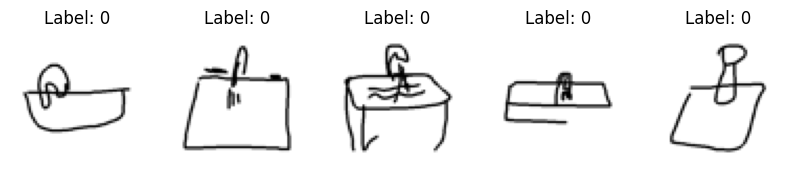

Testing Data - Total images loaded: 1166
Testing Data - Shape of images array: (1166, 64, 64)
Testing Data - Sample labels: [0 0 0 0 0]


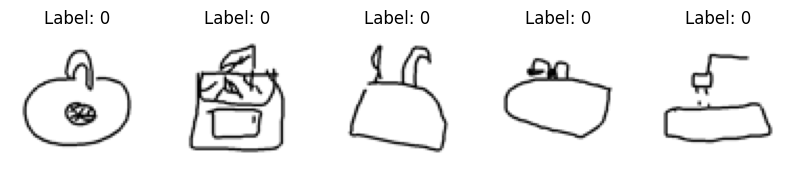

In [5]:
quickdraw_10_path = "QuickDraw-10/"

mapping = load_mapping(quickdraw_10_path + "mapping.txt")

train_images, train_labels = load_data(quickdraw_10_path + "train.txt")
test_images, test_labels = load_data(quickdraw_10_path + "test.txt")

verify_data(train_images, train_labels, "Training Data")
verify_data(test_images, test_labels, "Testing Data")

In [6]:
input_dim = 64*64
num_classes = 10

train_images = train_images.reshape(-1, input_dim)
test_images = test_images.reshape(-1, input_dim)

# Normalización
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

Training run 1 for MLP1
Run 1: Accuracy = 0.44, Loss = 1.6974
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 2 for MLP1
Run 2: Accuracy = 0.46, Loss = 1.7158
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Training run 3 for MLP1
Run 3: Accuracy = 0.42, Loss = 1.8052
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 4 for MLP1
Run 4: Accuracy = 0.48, Loss = 1.6289
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Training run 5 for MLP1
Run 5: Accuracy = 0.43, Loss = 1.7395
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


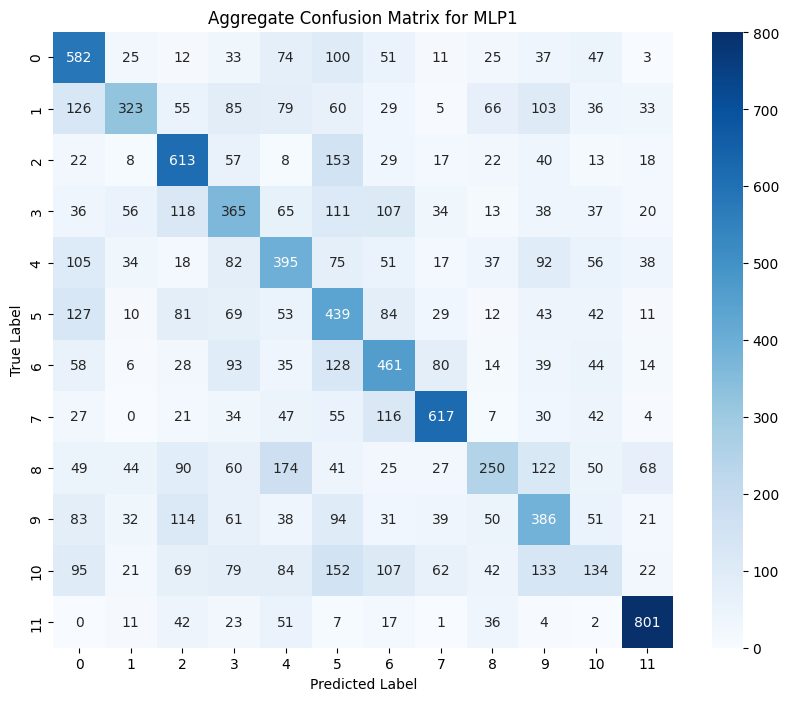

Median Class Accuracies for MLP1: [0.56, 0.345, 0.6, 0.285, 0.38, 0.45, 0.465, 0.675, 0.235, 0.375, 0.15, 0.8542713567839196]
Median Total Accuracy for MLP1: 0.45


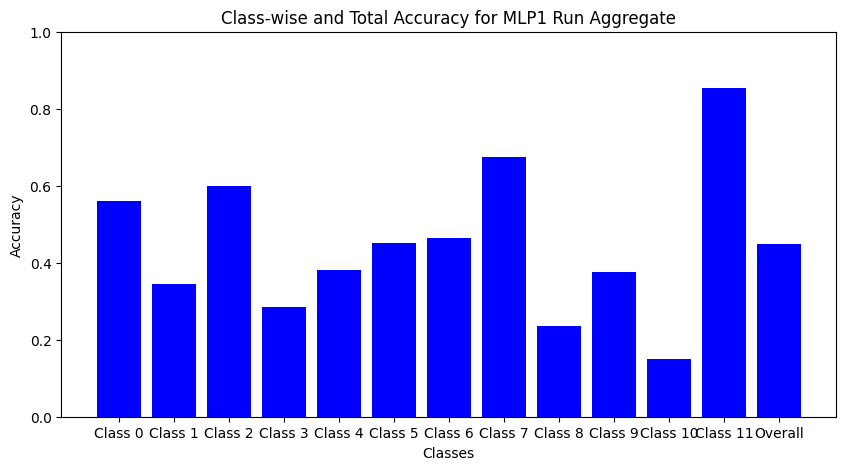

Training run 1 for MLP2
Run 1: Accuracy = 0.47, Loss = 1.6774
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 2 for MLP2
Run 2: Accuracy = 0.47, Loss = 1.6461
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 3 for MLP2
Run 3: Accuracy = 0.45, Loss = 1.7101
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 4 for MLP2
Run 4: Accuracy = 0.08, Loss = 2.4849
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 5 for MLP2
Run 5: Accuracy = 0.45, Loss = 1.7372
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


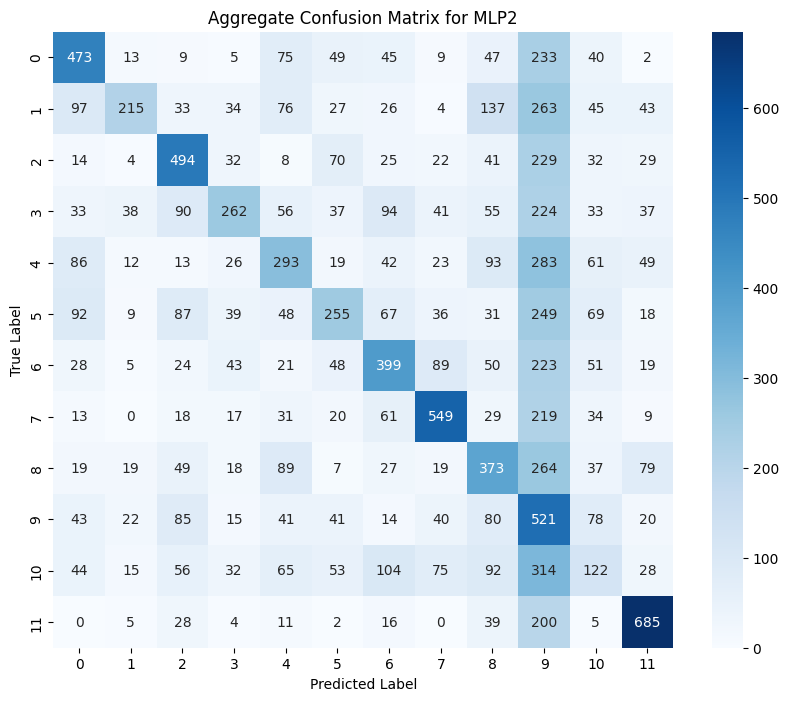

Median Class Accuracies for MLP2: [0.545, 0.275, 0.59, 0.315, 0.35, 0.26, 0.48, 0.625, 0.455, 0.445, 0.1, 0.8341708542713567]
Median Total Accuracy for MLP2: 0.39


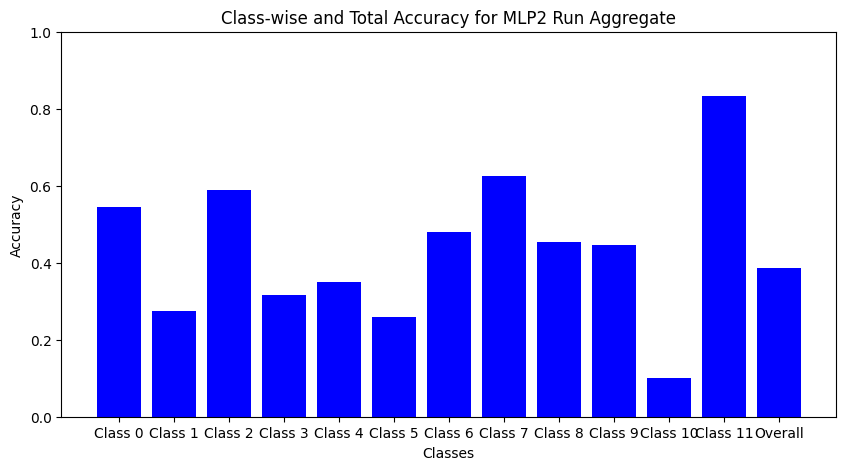

Training run 1 for MLP3
Run 1: Accuracy = 0.08, Loss = 2.4850
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 2 for MLP3
Run 2: Accuracy = 0.08, Loss = 2.4851
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 3 for MLP3
Run 3: Accuracy = 0.37, Loss = 1.8629
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 4 for MLP3
Run 4: Accuracy = 0.08, Loss = 2.4850
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 5 for MLP3
Run 5: Accuracy = 0.08, Loss = 2.4851
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


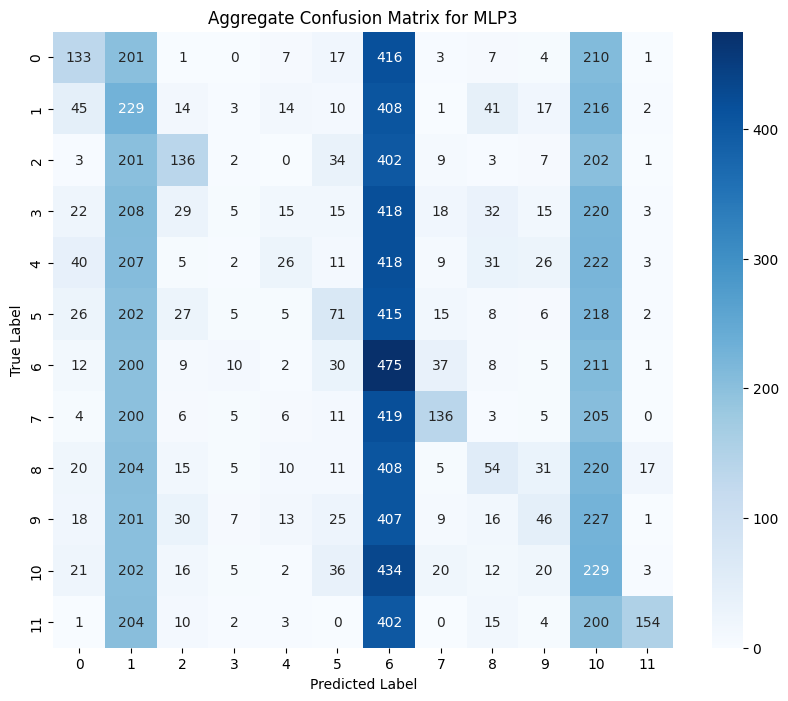

Median Class Accuracies for MLP3: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375, 0.0, 0.0, 0.0, 0.0, 0.0]
Median Total Accuracy for MLP3: 0.14


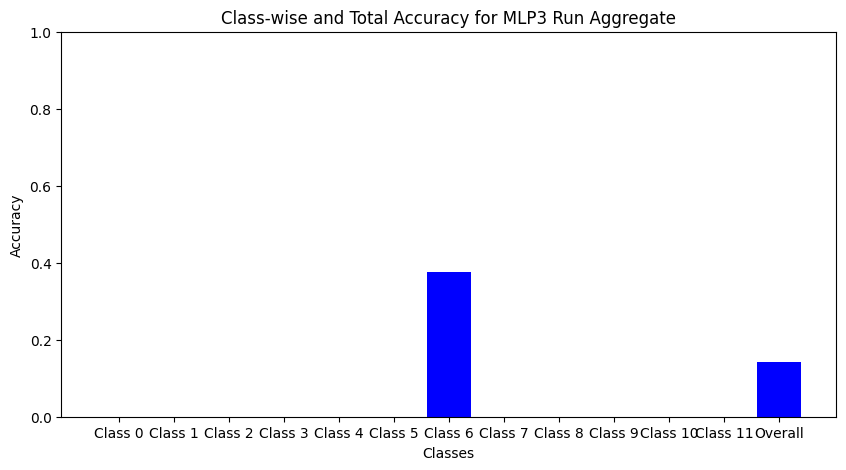

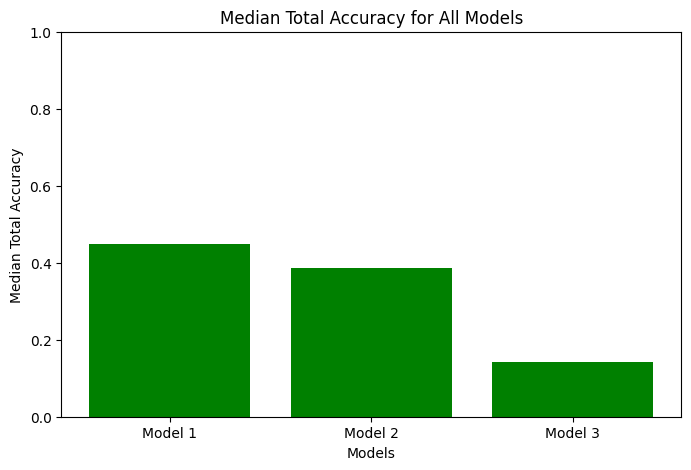

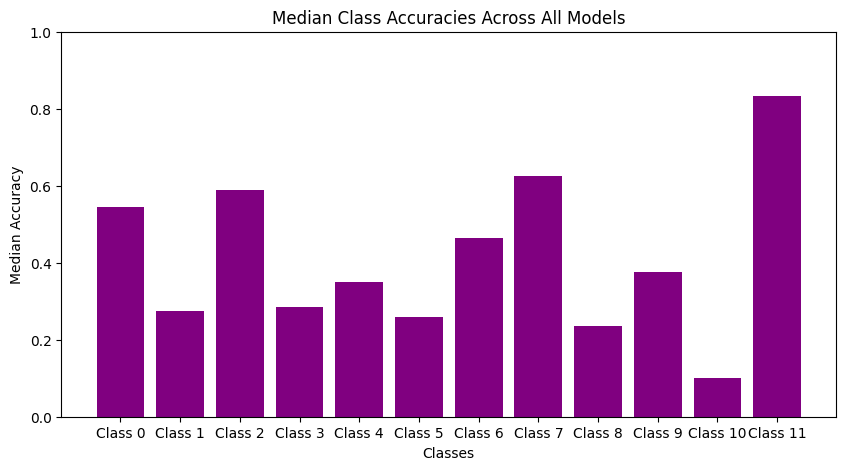

In [16]:
all_median_class_accuracies = []
all_median_total_accuracies = []

for model_num in range(1, 4):
    median_class_accuracies, median_total_accuracy = train_model(model_num, input_dim, num_classes, train_images, train_labels, test_images, test_labels)
    all_median_class_accuracies.append(median_class_accuracies)
    all_median_total_accuracies.append(median_total_accuracy)

# Gráficos de los resultados
plot_overall_model_accuracies(all_median_total_accuracies)
plot_median_class_accuracies(all_median_class_accuracies, num_classes)

### Quickdraw Animals

Training Data - Total images loaded: 12000
Training Data - Shape of images array: (12000, 64, 64)
Training Data - Sample labels: [1 1 1 1 1]


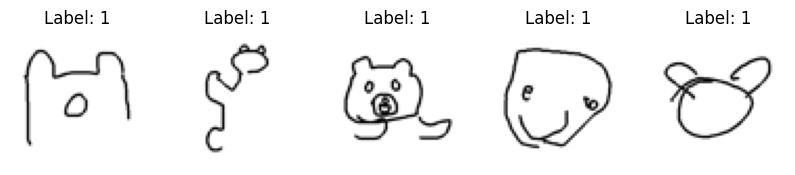

Testing Data - Total images loaded: 2399
Testing Data - Shape of images array: (2399, 64, 64)
Testing Data - Sample labels: [1 1 1 1 1]


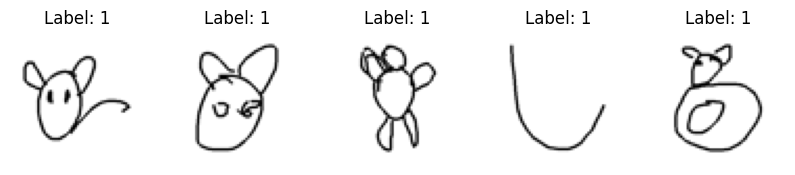

In [12]:
quickdraw_animals_path = "QuickDraw-Animals/"

mapping = load_mapping(quickdraw_animals_path +"mapping.txt")

train_images, train_labels = load_images_from_folder(quickdraw_animals_path + "train_images", mapping)
test_images, test_labels = load_images_from_folder(quickdraw_animals_path + "test_images", mapping)

verify_data(train_images, train_labels, "Training Data")
verify_data(test_images, test_labels, "Testing Data")

In [13]:
input_dim = 64*64
num_classes = 12

train_images = train_images.reshape(-1, input_dim)
test_images = test_images.reshape(-1, input_dim)

# Normalización
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

Training run 1 for MLP1
Run 1: Accuracy = 0.43, Loss = 1.7392
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 2 for MLP1
Run 2: Accuracy = 0.48, Loss = 1.6925
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 3 for MLP1
Run 3: Accuracy = 0.48, Loss = 1.6423
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 4 for MLP1
Run 4: Accuracy = 0.45, Loss = 1.7189
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 5 for MLP1
Run 5: Accuracy = 0.45, Loss = 1.7141
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


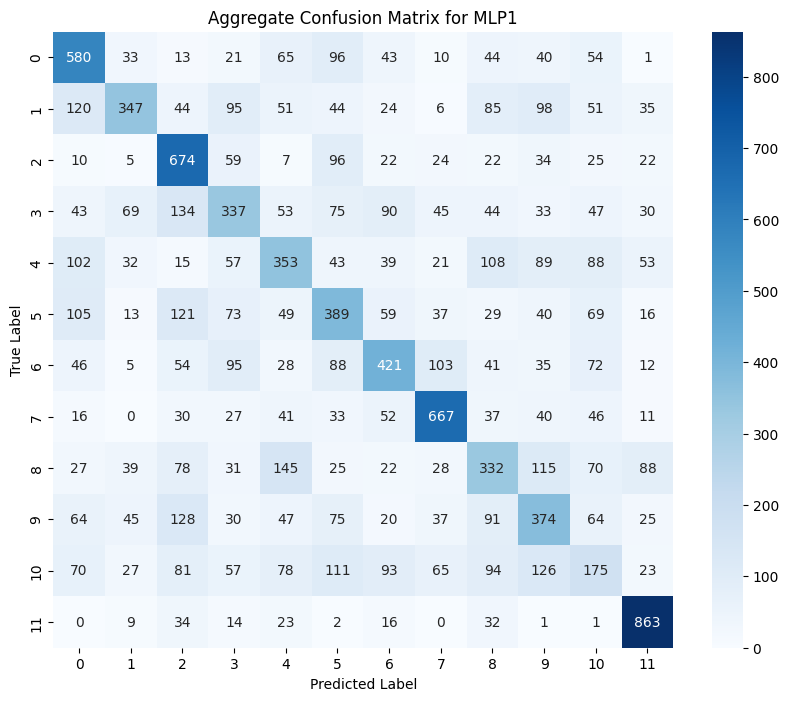

Median Class Accuracies for MLP1: [0.53, 0.355, 0.66, 0.305, 0.325, 0.395, 0.39, 0.665, 0.285, 0.425, 0.225, 0.8944723618090452]
Median Total Accuracy for MLP1: 0.46


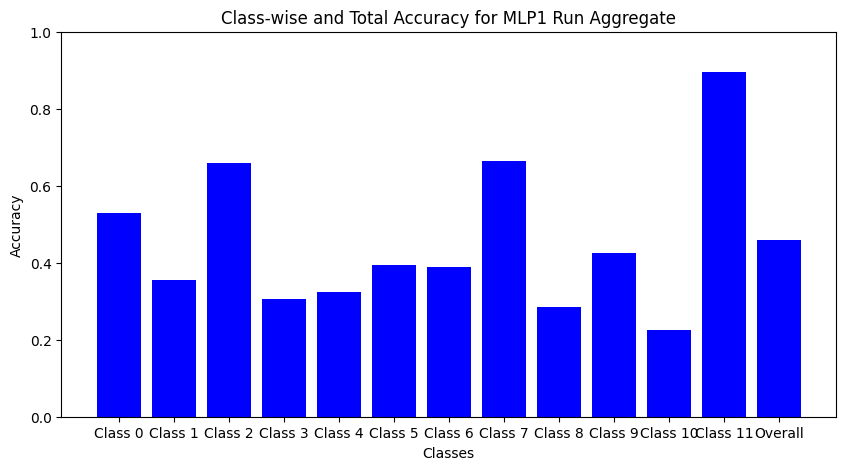

Training run 1 for MLP2
Run 1: Accuracy = 0.41, Loss = 1.8212
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training run 2 for MLP2
Run 2: Accuracy = 0.45, Loss = 1.7104
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training run 3 for MLP2
Run 3: Accuracy = 0.44, Loss = 1.7585
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 4 for MLP2
Run 4: Accuracy = 0.50, Loss = 1.6134
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training run 5 for MLP2
Run 5: Accuracy = 0.48, Loss = 1.6227
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


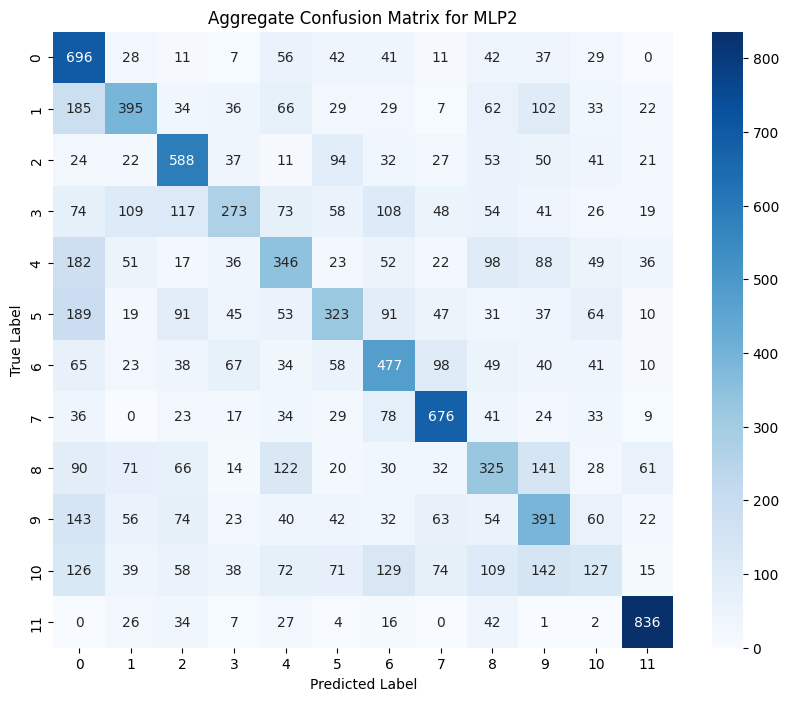

Median Class Accuracies for MLP2: [0.745, 0.41, 0.62, 0.28, 0.335, 0.35, 0.485, 0.685, 0.35, 0.38, 0.1, 0.8542713567839196]
Median Total Accuracy for MLP2: 0.45


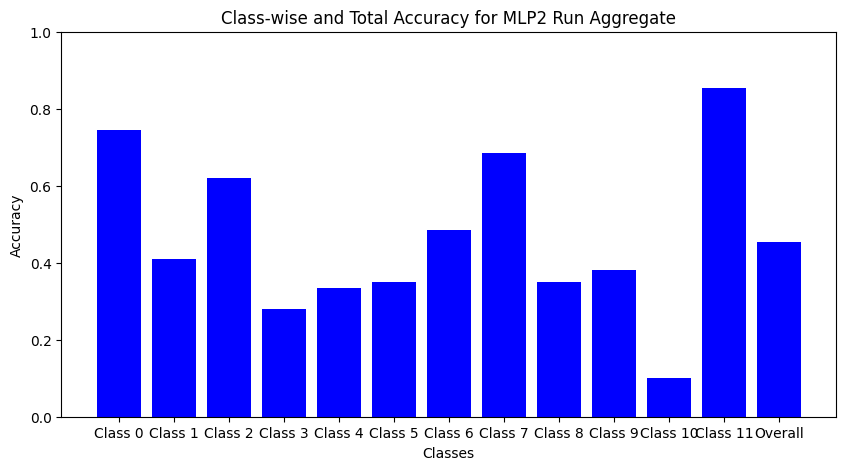

Training run 1 for MLP3
Run 1: Accuracy = 0.20, Loss = 2.1974
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training run 2 for MLP3
Run 2: Accuracy = 0.30, Loss = 2.0073
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training run 3 for MLP3
Run 3: Accuracy = 0.39, Loss = 1.8401
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 4 for MLP3
Run 4: Accuracy = 0.42, Loss = 1.7584
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training run 5 for MLP3
Run 5: Accuracy = 0.08, Loss = 2.4850
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


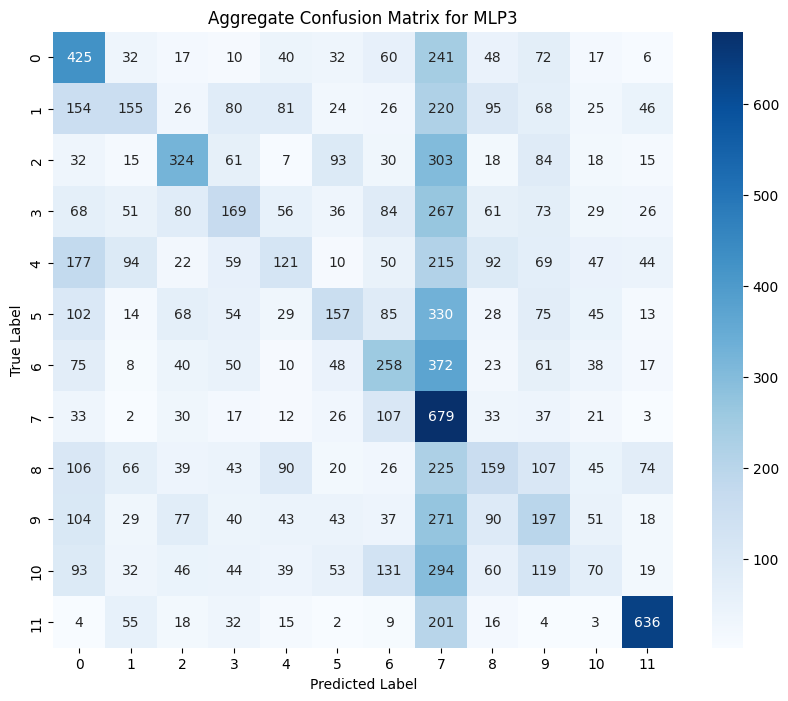

Median Class Accuracies for MLP3: [0.555, 0.165, 0.49, 0.025, 0.13, 0.115, 0.13, 0.61, 0.14, 0.18, 0.04, 0.7437185929648241]
Median Total Accuracy for MLP3: 0.28


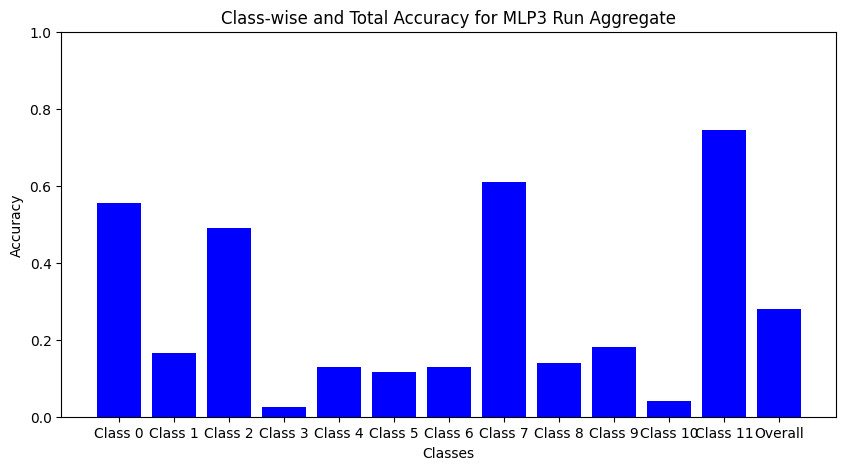

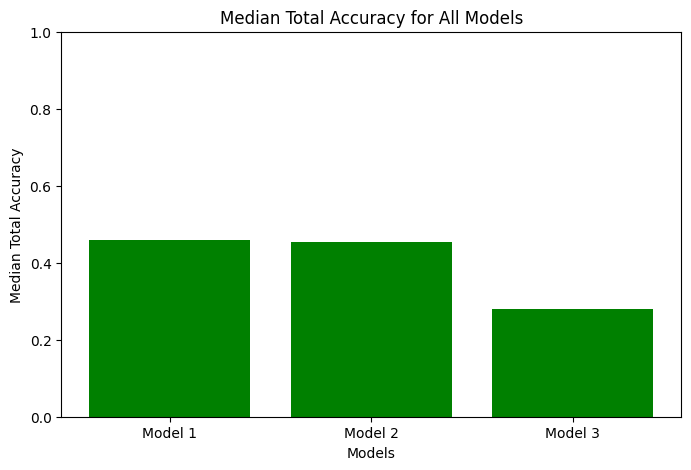

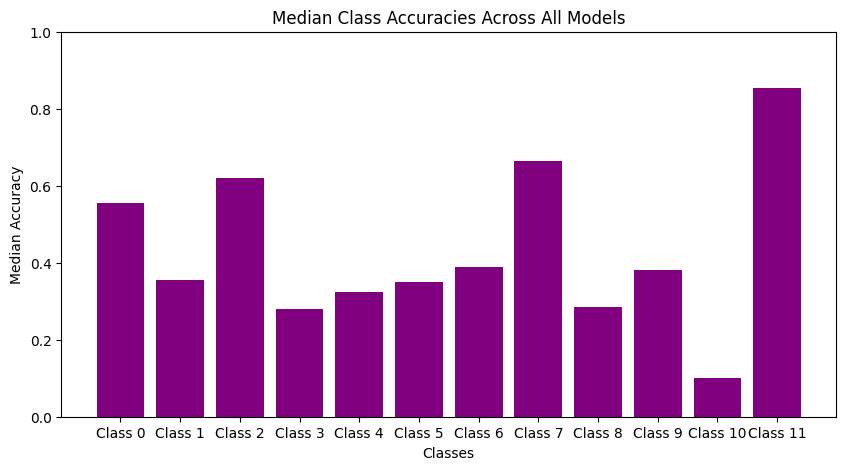

In [14]:
all_median_class_accuracies = []
all_median_total_accuracies = []

for model_num in range(1, 4):
    median_class_accuracies, median_total_accuracy = train_model(model_num, input_dim, num_classes, train_images, train_labels, test_images, test_labels)
    all_median_class_accuracies.append(median_class_accuracies)
    all_median_total_accuracies.append(median_total_accuracy)

# Gráficos de los resultados
plot_overall_model_accuracies(all_median_total_accuracies)
plot_median_class_accuracies(all_median_class_accuracies, num_classes)

#### Diagramas de bloques

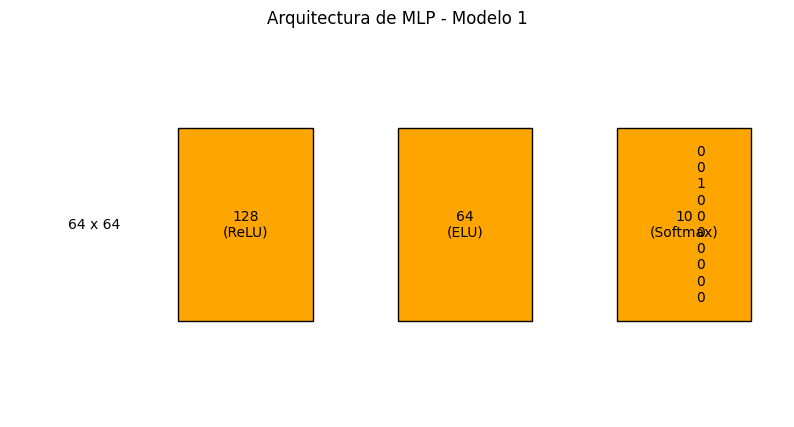

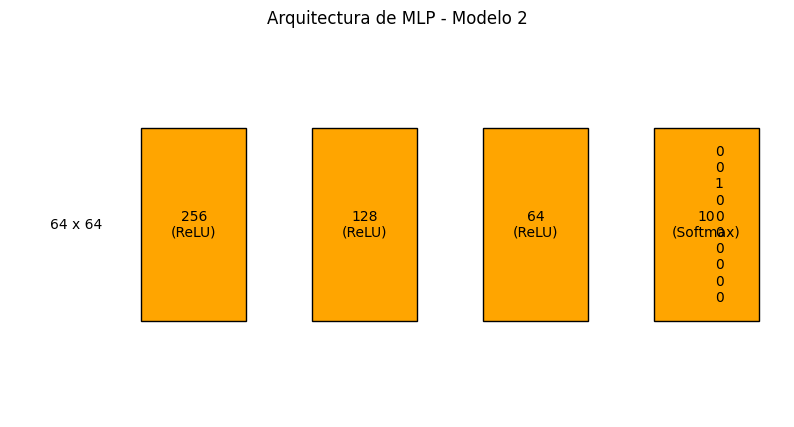

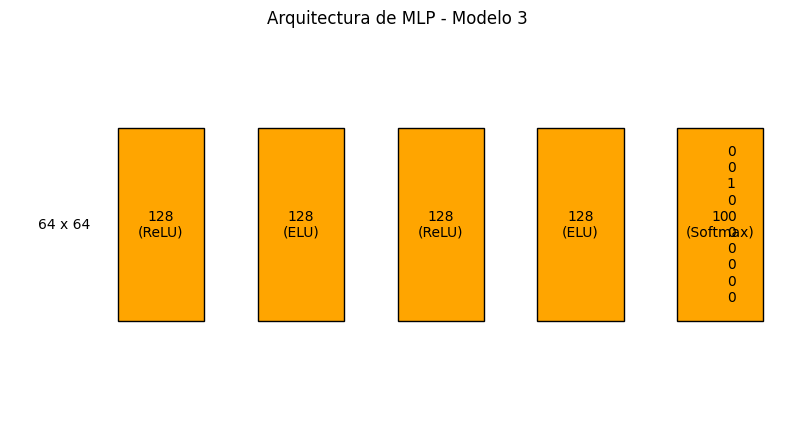

In [16]:
import matplotlib.pyplot as plt

def create_block_diagram(layers, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    num_layers = len(layers)
    layer_width = 0.8
    layer_height = 1
    spacing = 0.5
    total_width = (num_layers - 1) * (layer_width + spacing)
    
    # Draw the layers
    for i, (neurons, activation) in enumerate(layers):
        rect = plt.Rectangle((i * (layer_width + spacing), 0), layer_width, layer_height, facecolor='orange', edgecolor='black')
        ax.add_patch(rect)
        ax.text(i * (layer_width + spacing) + layer_width / 2, layer_height / 2, f'{neurons}\n({activation})', ha='center', va='center', fontsize=10)
    
    # Draw the input and output
    ax.text(-spacing, layer_height / 2, '64 x 64', ha='center', va='center', fontsize=10)
    ax.text(total_width + spacing, layer_height / 2, '0\n0\n1\n0\n0\n0\n0\n0\n0\n0', ha='center', va='center', fontsize=10)
    
    ax.set_xlim(-2 * spacing, total_width + 2 * spacing)
    ax.set_ylim(-0.5, layer_height + 0.5)
    ax.axis('off')
    
    plt.title(title)
    plt.show()

# Model 1
layers_model_1 = [(128, 'ReLU'), (64, 'ELU'), (10, 'Softmax')]
create_block_diagram(layers_model_1, 'Arquitectura de MLP - Modelo 1')

# Model 2
layers_model_2 = [(256, 'ReLU'), (128, 'ReLU'), (64, 'ReLU'), (10, 'Softmax')]
create_block_diagram(layers_model_2, 'Arquitectura de MLP - Modelo 2')

# Model 3
layers_model_3 = [(128, 'ReLU'), (128, 'ELU'), (128, 'ReLU'), (128, 'ELU'), (10, 'Softmax')]
create_block_diagram(layers_model_3, 'Arquitectura de MLP - Modelo 3')
